In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import matplotlib as mpl
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'times new roman'
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'

In [2]:
from astropy.table import Table
import astropy.units as u
import astropy.constants as c

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [4]:
import sys
sys.path.append('../tools/')
from dust_extinction import calALambda
from data_binning import data_binning

In [5]:
# mjd, mag, mag_unc
# upper limits: mag = 5sigma, mag_unc = -999
X = np.loadtxt('SN2020jgb_ZTF_g.dat')
Y = np.loadtxt('SN2020jgb_ZTF_r.dat')

In [6]:
tfo = min(X[np.argwhere(X[:, -1] > 0)[0], 0], Y[np.argwhere(Y[:, -1] > 0)[0],
                                                0])[0]
tno = max(X[np.argwhere(X[:, -1] > 0)[0] - 1, 0],
          Y[np.argwhere(Y[:, -1] > 0)[0] - 1, 0])[0]
tfl = (tfo + tno) / 2
tfl_unc = (tfo - tno) / 2
print(tfl, tfl_unc)

58969.470214999994 2.992744999999559


In [7]:
tp = 58983.6

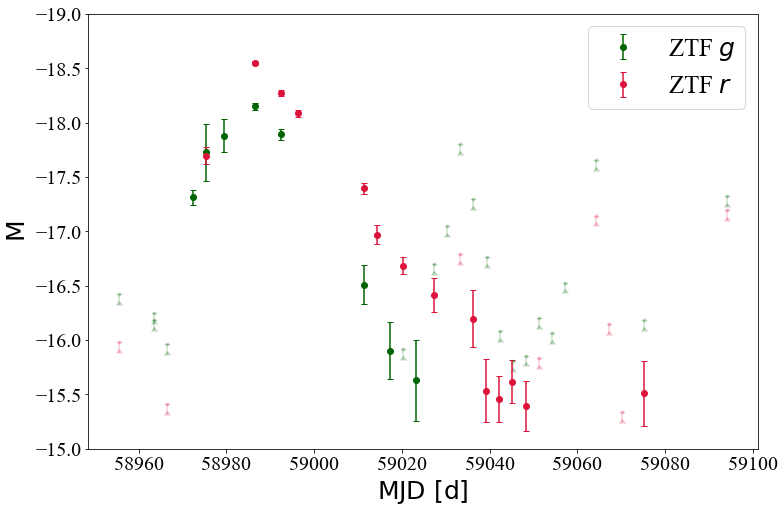

In [8]:
plt.figure(figsize=(12, 8))

T, Mag, Mag_unc = [], [], []
for x, label, col in zip([X, Y], ['ZTF $g$', 'ZTF $r$'],
                         ['darkgreen', 'crimson']):
    t = x[x[:, 2] > 0, 0]
    mag = x[x[:, 2] > 0, 1]
    mag_unc = x[x[:, 2] > 0, 2]
    
    T.append(t)
    Mag.append(mag)
    Mag_unc.append(mag_unc)

    t_lim = x[x[:, 2] < 0, 0]
    lim = x[x[:, 2] < 0, 1]

    plt.errorbar(t,
                 mag,
                 yerr=mag_unc,
                 fmt='o',
                 capsize=3,
                 color=col,
                 label=label)
    plt.errorbar(t_lim,
                 lim + .1,
                 yerr=.1,
                 lolims=True,
                 fmt='.',
                 capsize=3,
                 color=col,
                 alpha=0.2)

    '''kernel = 1 * RBF(length_scale=1.0,
                     length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
                         noise_level=1, noise_level_bounds=(1e-10, 1e1))

    gp = GPR(kernel=kernel, alpha=mag_unc**2, n_restarts_optimizer=10)
    gp.fit(np.atleast_2d(t).T, mag)

    tgp = np.linspace(tfl - tfl_unc, 59030, 100)
    mag_pred, dmag_pred = gp.predict(np.atleast_2d(tgp).T, return_std=1)

    plt.fill_between(tgp,
                     mag_pred - dmag_pred,
                     mag_pred + dmag_pred,
                     color=col,
                     alpha=0.5)'''

plt.ylim(-19, -15)
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel(r'$\mathrm{MJD\ [d]}$')
plt.ylabel(r'$\mathrm{M}$')
plt.show()

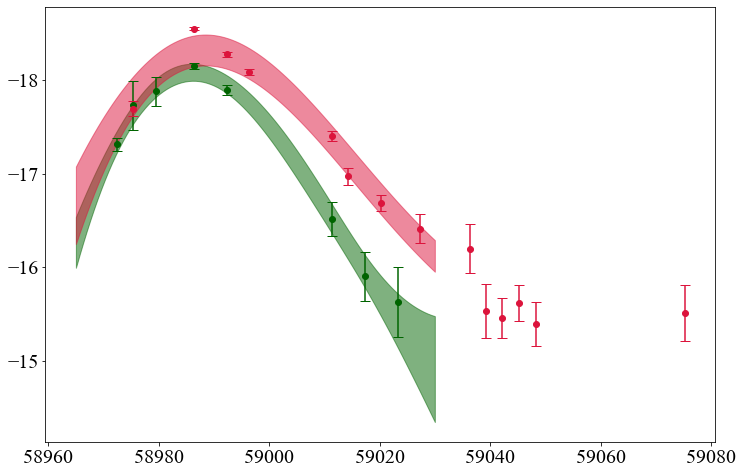

In [9]:
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(
    1e-2, 1e3)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))

tG = np.atleast_2d(X[X[:, 2] > 0, 0]).T
gmag = X[X[:, 2] > 0, 1]
gmag_unc = X[X[:, 2] > 0, 2]

tR = np.atleast_2d(Y[Y[:, 2] > 0, 0]).T
rmag = Y[Y[:, 2] > 0, 1]
rmag_unc = Y[Y[:, 2] > 0, 2]

gpG = GPR(kernel=kernel, alpha=gmag_unc**2, n_restarts_optimizer=10)
gpG.fit(tG, gmag)
gpR = GPR(kernel=kernel, alpha=rmag_unc**2, n_restarts_optimizer=20)
gpR.fit(tR, rmag)

tgp = np.linspace(58965, 59030, 100)
tgp = np.atleast_2d(tgp).T
gmag_pred, dgmag_pred = gpG.predict(tgp, return_std=1)
rmag_pred, drmag_pred = gpR.predict(tgp, return_std=1)

plt.figure(figsize=(12, 8))
plt.errorbar(tG.ravel(),
             gmag,
             yerr=gmag_unc,
             fmt='o',
             capsize=5,
             color='darkgreen')
plt.fill_between(tgp.ravel(),
                 gmag_pred.ravel() - dgmag_pred.ravel(),
                 gmag_pred.ravel() + dgmag_pred.ravel(),
                 color='darkgreen',
                 alpha=0.5)
plt.errorbar(tR.ravel(),
             rmag,
             yerr=rmag_unc,
             fmt='o',
             capsize=5,
             color='crimson')
plt.fill_between(tgp.ravel(),
                 rmag_pred.ravel() - drmag_pred.ravel(),
                 rmag_pred.ravel() + drmag_pred.ravel(),
                 color='crimson',
                 alpha=0.5)
plt.gca().invert_yaxis()

# Abi's models

## g, r

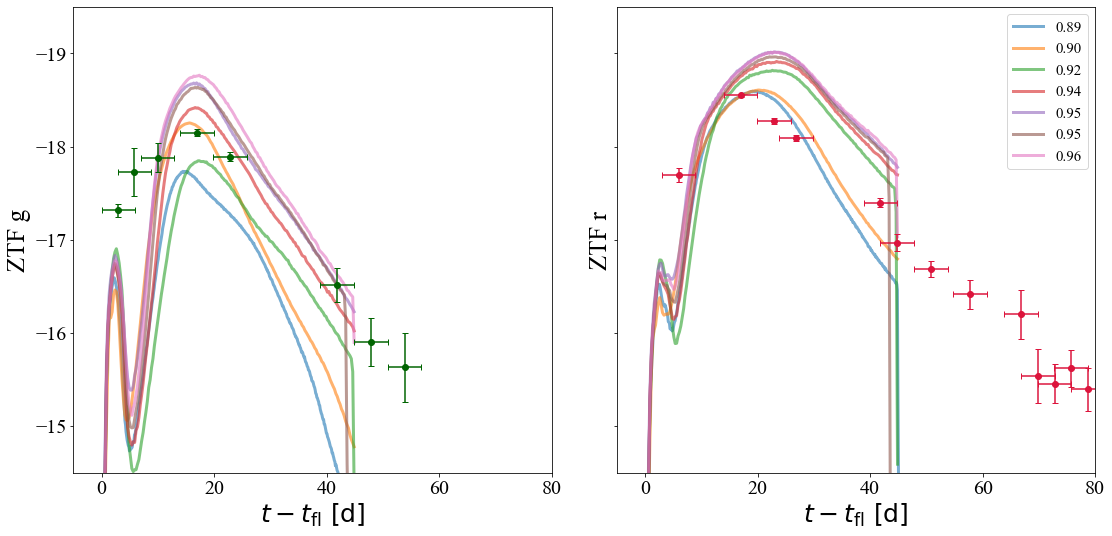

In [10]:
model = glob.glob('../../polin19_models/0.05s/*.mag')
model.sort()

f, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
for mod in model:
    pos = mod.find('good_')
    if pos == -1:
        #continue
        pos = mod.find('.05s/')
    mass = mod[pos + 5:][:mod[pos + 5:].find('_')]
    dat = np.loadtxt(mod)
    if (-19.5 < dat[:, 3].min() < -17.5) and (-19 < dat[:, 2].min() < -17):
        ax[0].plot(dat[:, 0], dat[:, 2], linewidth=3, alpha=0.6)  #g-band
        ax[1].plot(dat[:, 0], dat[:, 3], linewidth=3, label=mass,
                   alpha=0.6)  #r-band
ax[0].errorbar(T[0] - tfl,
               Mag[0],
               xerr=tfl_unc,
               yerr=Mag_unc[0],
               fmt='o',
               capsize=3,
               color='darkgreen')
ax[1].errorbar(T[1] - tfl,
               Mag[1],
               xerr=tfl_unc,
               yerr=Mag_unc[1],
               fmt='o',
               capsize=3,
               color='crimson')
ax[0].invert_yaxis()
ax[0].set_ylim(-14.5, -19.5)
ax[0].set_xlim(-5, 80)
ax[0].set_xlabel('$t-t_\mathrm{fl}\ [\mathrm{d}]$')
ax[1].set_xlabel('$t-t_\mathrm{fl}\ [\mathrm{d}]$')
ax[0].set_ylabel('ZTF g')
ax[1].set_ylabel('ZTF r')
plt.legend(loc=1, prop={'size': 15})
plt.tight_layout()
plt.show()

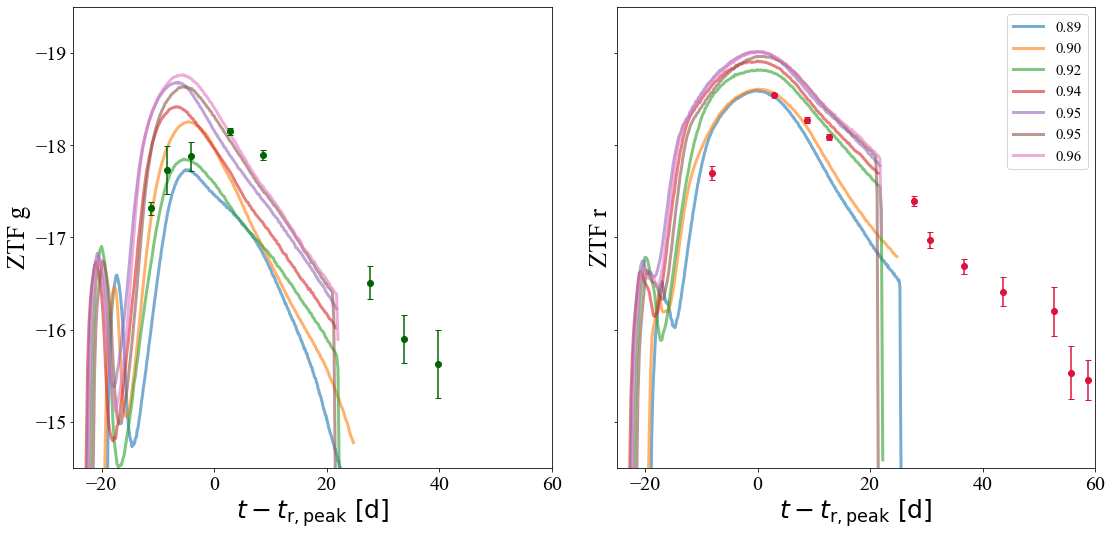

In [36]:
model = glob.glob('../../polin19_models/0.05s/*.mag')
model.sort()

f, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
for mod in model:
    pos = mod.find('good_')
    if pos == -1:
        #continue
        pos = mod.find('.05s/')
    mass = mod[pos + 5:][:mod[pos + 5:].find('_')]
    dat = np.loadtxt(mod)
    if (-19.5 < dat[:, 3].min() < -17.5) and (-19 < dat[:, 2].min() < -17):
        ax[0].plot(dat[:, 0] - dat[np.argmin(dat[:, 3]), 0],
                   dat[:, 2],
                   linewidth=3,
                   alpha=0.6)  #g-band
        ax[1].plot(dat[:, 0] - dat[np.argmin(dat[:, 3]), 0],
                   dat[:, 3],
                   linewidth=3,
                   label=mass,
                   alpha=0.6)  #r-band
ax[0].errorbar(T[0] - tp,
               Mag[0],
               xerr=0.2,
               yerr=Mag_unc[0],
               fmt='o',
               capsize=3,
               color='darkgreen')
ax[1].errorbar(T[1] - tp,
               Mag[1],
               xerr=0.2,
               yerr=Mag_unc[1],
               fmt='o',
               capsize=3,
               color='crimson')
ax[0].invert_yaxis()
ax[0].set_ylim(-14.5, -19.5)
ax[0].set_xlim(-25, 60)
ax[0].set_xlabel('$t-t_\mathrm{r, peak}\ [\mathrm{d}]$')
ax[1].set_xlabel('$t-t_\mathrm{r, peak}\ [\mathrm{d}]$')
ax[0].set_ylabel('ZTF g')
ax[1].set_ylabel('ZTF r')
plt.legend(loc=1, prop={'size': 15})
plt.tight_layout()
plt.show()

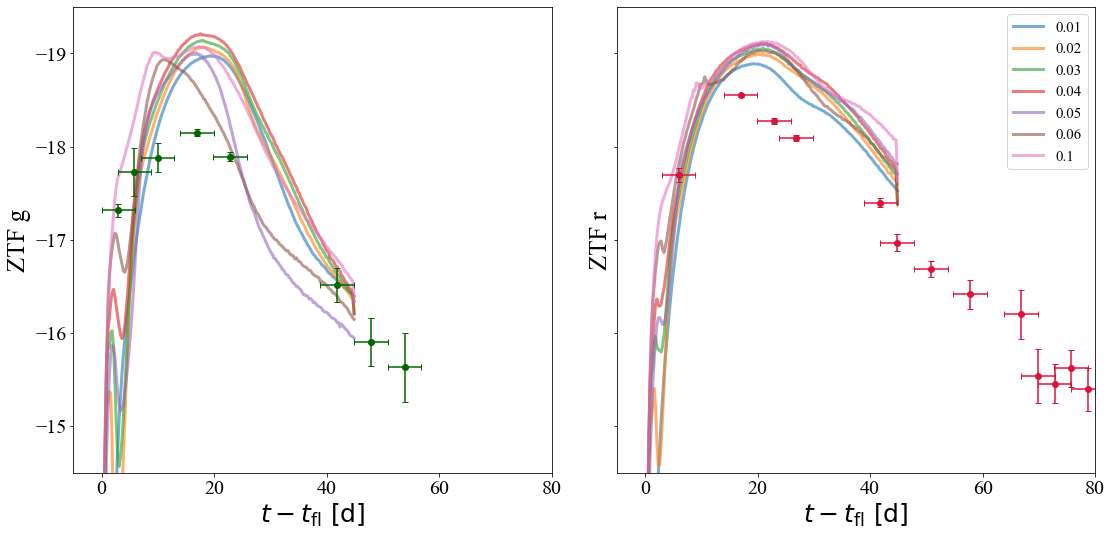

In [43]:
model = glob.glob('../../polin19_models/1.0WDs/*.mag')
model.sort()

f, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
for mod in model:
    mass = mod[mod.find('1.0_') + 4:max(mod.find('_d'), mod.find('_e'))]
    dat = np.loadtxt(mod)
    if (-19.2 < dat[:, 3].min() < -17.5):
        ax[0].plot(dat[:, 0], dat[:, 2], linewidth=3, alpha=0.6)  #g-band
        ax[1].plot(dat[:, 0], dat[:, 3], linewidth=3, label=mass,
                   alpha=0.6)  #r-band
ax[0].errorbar(T[0] - tfl,
               Mag[0],
               xerr=tfl_unc,
               yerr=Mag_unc[0],
               fmt='o',
               capsize=3,
               color='darkgreen')
ax[1].errorbar(T[1] - tfl,
               Mag[1],
               xerr=tfl_unc,
               yerr=Mag_unc[1],
               fmt='o',
               capsize=3,
               color='crimson')
ax[0].invert_yaxis()
ax[0].set_ylim(-14.5, -19.5)
ax[0].set_xlim(-5, 80)
ax[0].set_xlabel('$t-t_\mathrm{fl}\ [\mathrm{d}]$')
ax[1].set_xlabel('$t-t_\mathrm{fl}\ [\mathrm{d}]$')
ax[0].set_ylabel('ZTF g')
ax[1].set_ylabel('ZTF r')
plt.legend(loc=1, prop={'size': 15})
plt.tight_layout()
plt.show()

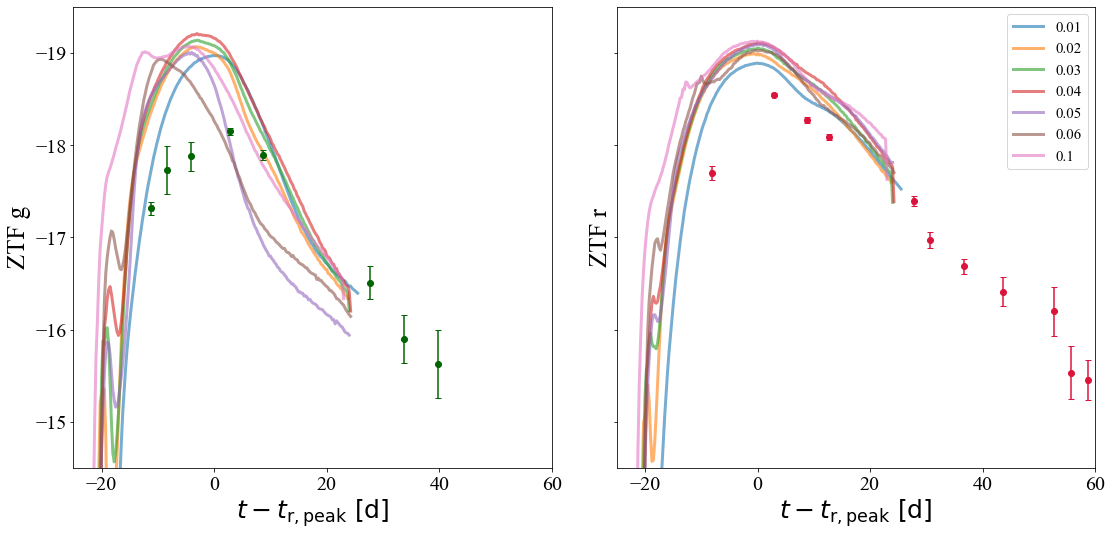

In [40]:
model = glob.glob('../../polin19_models/1.0WDs/*.mag')
model.sort()

f, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
for mod in model:
    mass = mod[mod.find('1.0_') + 4:max(mod.find('_d'), mod.find('_e'))]
    dat = np.loadtxt(mod)
    if (-19.2 < dat[:, 3].min() < -17.5):
        ax[0].plot(dat[:, 0] - dat[np.argmin(dat[:, 3]), 0],
                   dat[:, 2],
                   linewidth=3, alpha=0.6)  #g-band
        ax[1].plot(dat[:, 0] - dat[np.argmin(dat[:, 3]), 0],
                   dat[:, 3],
                   linewidth=3,
                   label=mass, alpha=0.6)  #r-band
ax[0].errorbar(T[0] - tp,
               Mag[0],
               xerr=0.2,
               yerr=Mag_unc[0],
               fmt='o',
               capsize=3,
               color='darkgreen')
ax[1].errorbar(T[1] - tp,
               Mag[1],
               xerr=0.2,
               yerr=Mag_unc[1],
               fmt='o',
               capsize=3,
               color='crimson')
ax[0].invert_yaxis()
ax[0].set_ylim(-14.5, -19.5)
ax[0].set_xlim(-25, 60)
ax[0].set_xlabel('$t-t_\mathrm{r, peak}\ [\mathrm{d}]$')
ax[1].set_xlabel('$t-t_\mathrm{r, peak}\ [\mathrm{d}]$')
ax[0].set_ylabel('ZTF g')
ax[1].set_ylabel('ZTF r')
plt.legend(loc=1, prop={'size': 15})
plt.tight_layout()
plt.show()

## g-r

In [11]:
# From Bulla, Miller+2020

gr_population = pd.read_csv('color/gr_adam.txt', 
                            delim_whitespace=True, comment='#',
                            names=['SN', 't', 'e_t_min', 'e_t_max', 
                                   'gr', 'e_gr_min', 'e_gr_max',
                                   'type', 'marker'])

normal_ia = np.where((gr_population.type == 'normal*') |
                     (gr_population.type == 'normal') | 
                     (gr_population.type == '91T-like') |
                     (gr_population.type == '99aa-like') | 
                     (gr_population.type == '99aa-like*')
                    )

print('There are {} normal SNe in this sample'.format(len(gr_population.iloc[normal_ia].SN.unique())))

gr_population.head(5)

There are 62 normal SNe in this sample


,SN,t,e_t_min,e_t_max,gr,e_gr_min,e_gr_max,type,marker
0,ZTF18aapqwyv,2.111188,0.685375,0.529521,0.242970,0.368273,0.384782,normal*,o
1,ZTF18aapqwyv,3.032216,0.685375,0.529521,0.945111,0.297778,0.358075,normal*,o
2,ZTF18aapqwyv,3.974450,0.685375,0.529521,0.270548,0.168496,0.161108,normal*,o
3,ZTF18aapqwyv,4.973797,0.685375,0.529521,0.125119,0.193820,0.177315,normal*,o
4,ZTF18aapqwyv,16.227165,0.685375,0.529521,-0.131547,0.033107,0.033027,normal*,o


In [12]:
def mag1_mag2(X, Y, bin_size=1, intp=False):
    t1, t2 = X[:, 0], Y[:, 0]
    mag1, mag2 = X[:, 1], Y[:, 1]
    unc1, unc2 = X[:, 2], Y[:, 2]
    if intp:
        t1, mag1, unc1 = interp(t1, mag1, unc1)
        t2, mag2, unc2 = interp(t2, mag2, unc2)
    #print(len(t1), len(mag1))
    i, j = 0, 0
    T = []
    dmag, Unc = [], []
    while i < len(t1):
        while t2[j] < t1[i] + bin_size:
            if (np.abs(t2[j] - t1[i]) < bin_size):
                t = (t1[i] / unc1[i]**2 +
                     t2[j] / unc2[j]**2) / (1 / unc1[i]**2 + 1 / unc2[j]**2)
                mag = (mag1[i] - mag2[j])
                unc = (unc1[i]**2 + unc2[j]**2)**.5
                T = np.append(T, t)
                dmag = np.append(dmag, mag)
                Unc = np.append(Unc, unc)
                break
            j += 1
        i += 1
    arg = np.argwhere(Unc < 999).flatten()
    return T[arg], dmag[arg], Unc[arg]

In [13]:
gr_gp = gmag_pred - rmag_pred
gr_unc_gp = (dgmag_pred**2 + drmag_pred**2)**.5

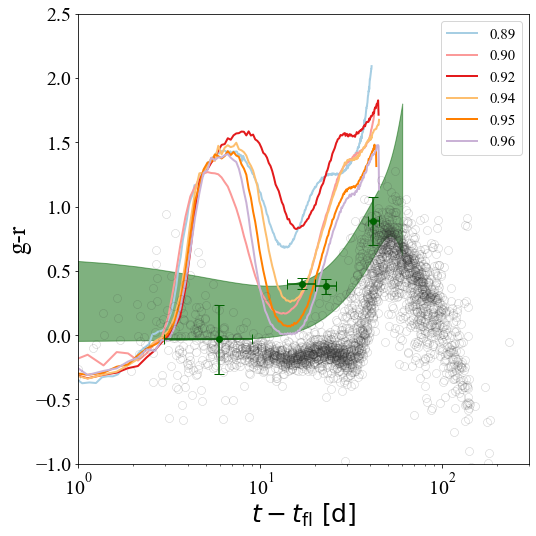

In [42]:
model = glob.glob('../../polin19_models/0.05s/*.mag')
model.sort()

color = [
    '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c',
    '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a'
]

plt.figure(figsize=(8, 8))
num_model = -1
for mod in model:
    pos = mod.find('good_')
    if pos == -1:
        #continue
        pos = mod.find('.05s/')
    if '55' in mod:
        continue
    num_model += 1
    mass = mod[pos + 5:][:mod[pos + 5:].find('_')]
    dat = np.loadtxt(mod)
    dat = np.array([d for d in dat if np.prod(d) != 0])
    while dat[-1, 2] - dat[:, 2].min() > 3:
        dat = dat[:-1]
    if (-19.5 < dat[:, 3].min() < -17.5) and (-19 < dat[:, 2].min() < -17):
        plt.plot(dat[:, 0],
                 dat[:, 2] - dat[:, 3],
                 label=mass,
                 linewidth=2,
                 color=color[num_model])
dT, dmag, Unc = mag1_mag2(X, Y, bin_size=1)
plt.errorbar(dT - tfl, dmag, xerr=tfl_unc, yerr=Unc, fmt='o', capsize=5, color='darkgreen')
tgp = tgp.ravel()
plt.fill_between(tgp - tfl,
                 gr_gp - gr_unc_gp,
                 gr_gp + gr_unc_gp,
                 color='darkgreen',
                 alpha=0.5)
plt.plot(gr_population.iloc[normal_ia].t.values,
         gr_population.iloc[normal_ia].gr.values,
         'o',
         color='None',
         mec='0.2',
         mew=0.4,
         ms=8,
         alpha=0.3)
plt.ylim(-1, 2.5)
plt.xlim(1, 300)
plt.ylabel('g-r')
plt.xlabel('$t-t_\mathrm{fl}\ [\mathrm{d}]$')
plt.legend(loc=1, prop={'size': 15})
plt.xscale('log')
plt.tight_layout()
plt.show()

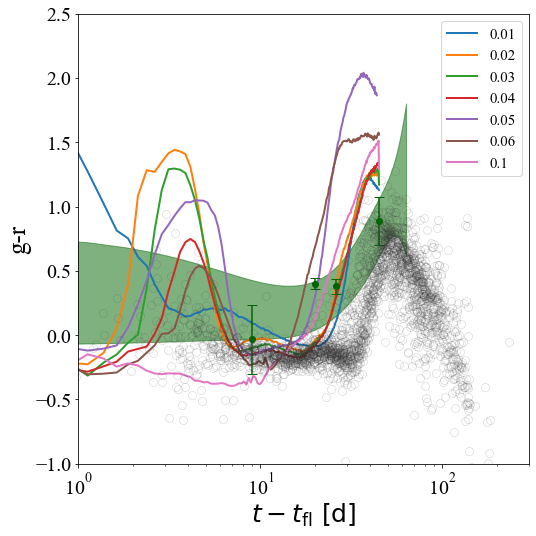

In [15]:
model = glob.glob('../../polin19_models/1.0WDs/*.mag')
model.sort()

plt.figure(figsize=(8, 8))
for mod in model:
    mass = mod[mod.find('1.0_') + 4:max(mod.find('_d'), mod.find('_e'))]
    dat = np.loadtxt(mod)
    dat = np.array([d for d in dat if np.prod(d) != 0])
    while dat[-1, 2] - dat[:, 2].min() > 3:
        dat = dat[:-1]
    if (-19.2 < dat[:, 3].min() < -17.5):
        plt.plot(dat[:, 0], dat[:, 2] - dat[:, 3], label=mass, linewidth=2)
dT, dmag, Unc = mag1_mag2(X, Y, bin_size=1)
plt.errorbar(dT - tfl, dmag, yerr=Unc, fmt='o', capsize=5, color='darkgreen')
plt.fill_between(tgp - tfl,
                 gr_gp - gr_unc_gp,
                 gr_gp + gr_unc_gp,
                 color='darkgreen',
                 alpha=0.5)
plt.plot(gr_population.iloc[normal_ia].t.values,
         gr_population.iloc[normal_ia].gr.values,
         'o',
         color='None',
         mec='0.2',
         mew=0.4,
         ms=8,
         alpha=0.3)
plt.ylim(-1, 2.5)
plt.xlim(1, 300)
plt.ylabel('g-r')
plt.xlabel('$t-t_\mathrm{fl}\ [\mathrm{d}]$')
plt.legend(loc=1, prop={'size': 15})
plt.xscale('log')
plt.tight_layout()
plt.show()